In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats
import scipy.io as scio

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt

#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
#############################################################
# Xanthos grid info
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
#GRDC list
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
#GRDC data
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')
##
nbasins = GRDC_xanthosCoordIndx.shape[0]
basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(nbasins)]

## flow data
grdc_m3persec = np.zeros([nbasins, 240])
for ii in range(nbasins):   
    basin_num = basins91[ii]
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])


## Calibration

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

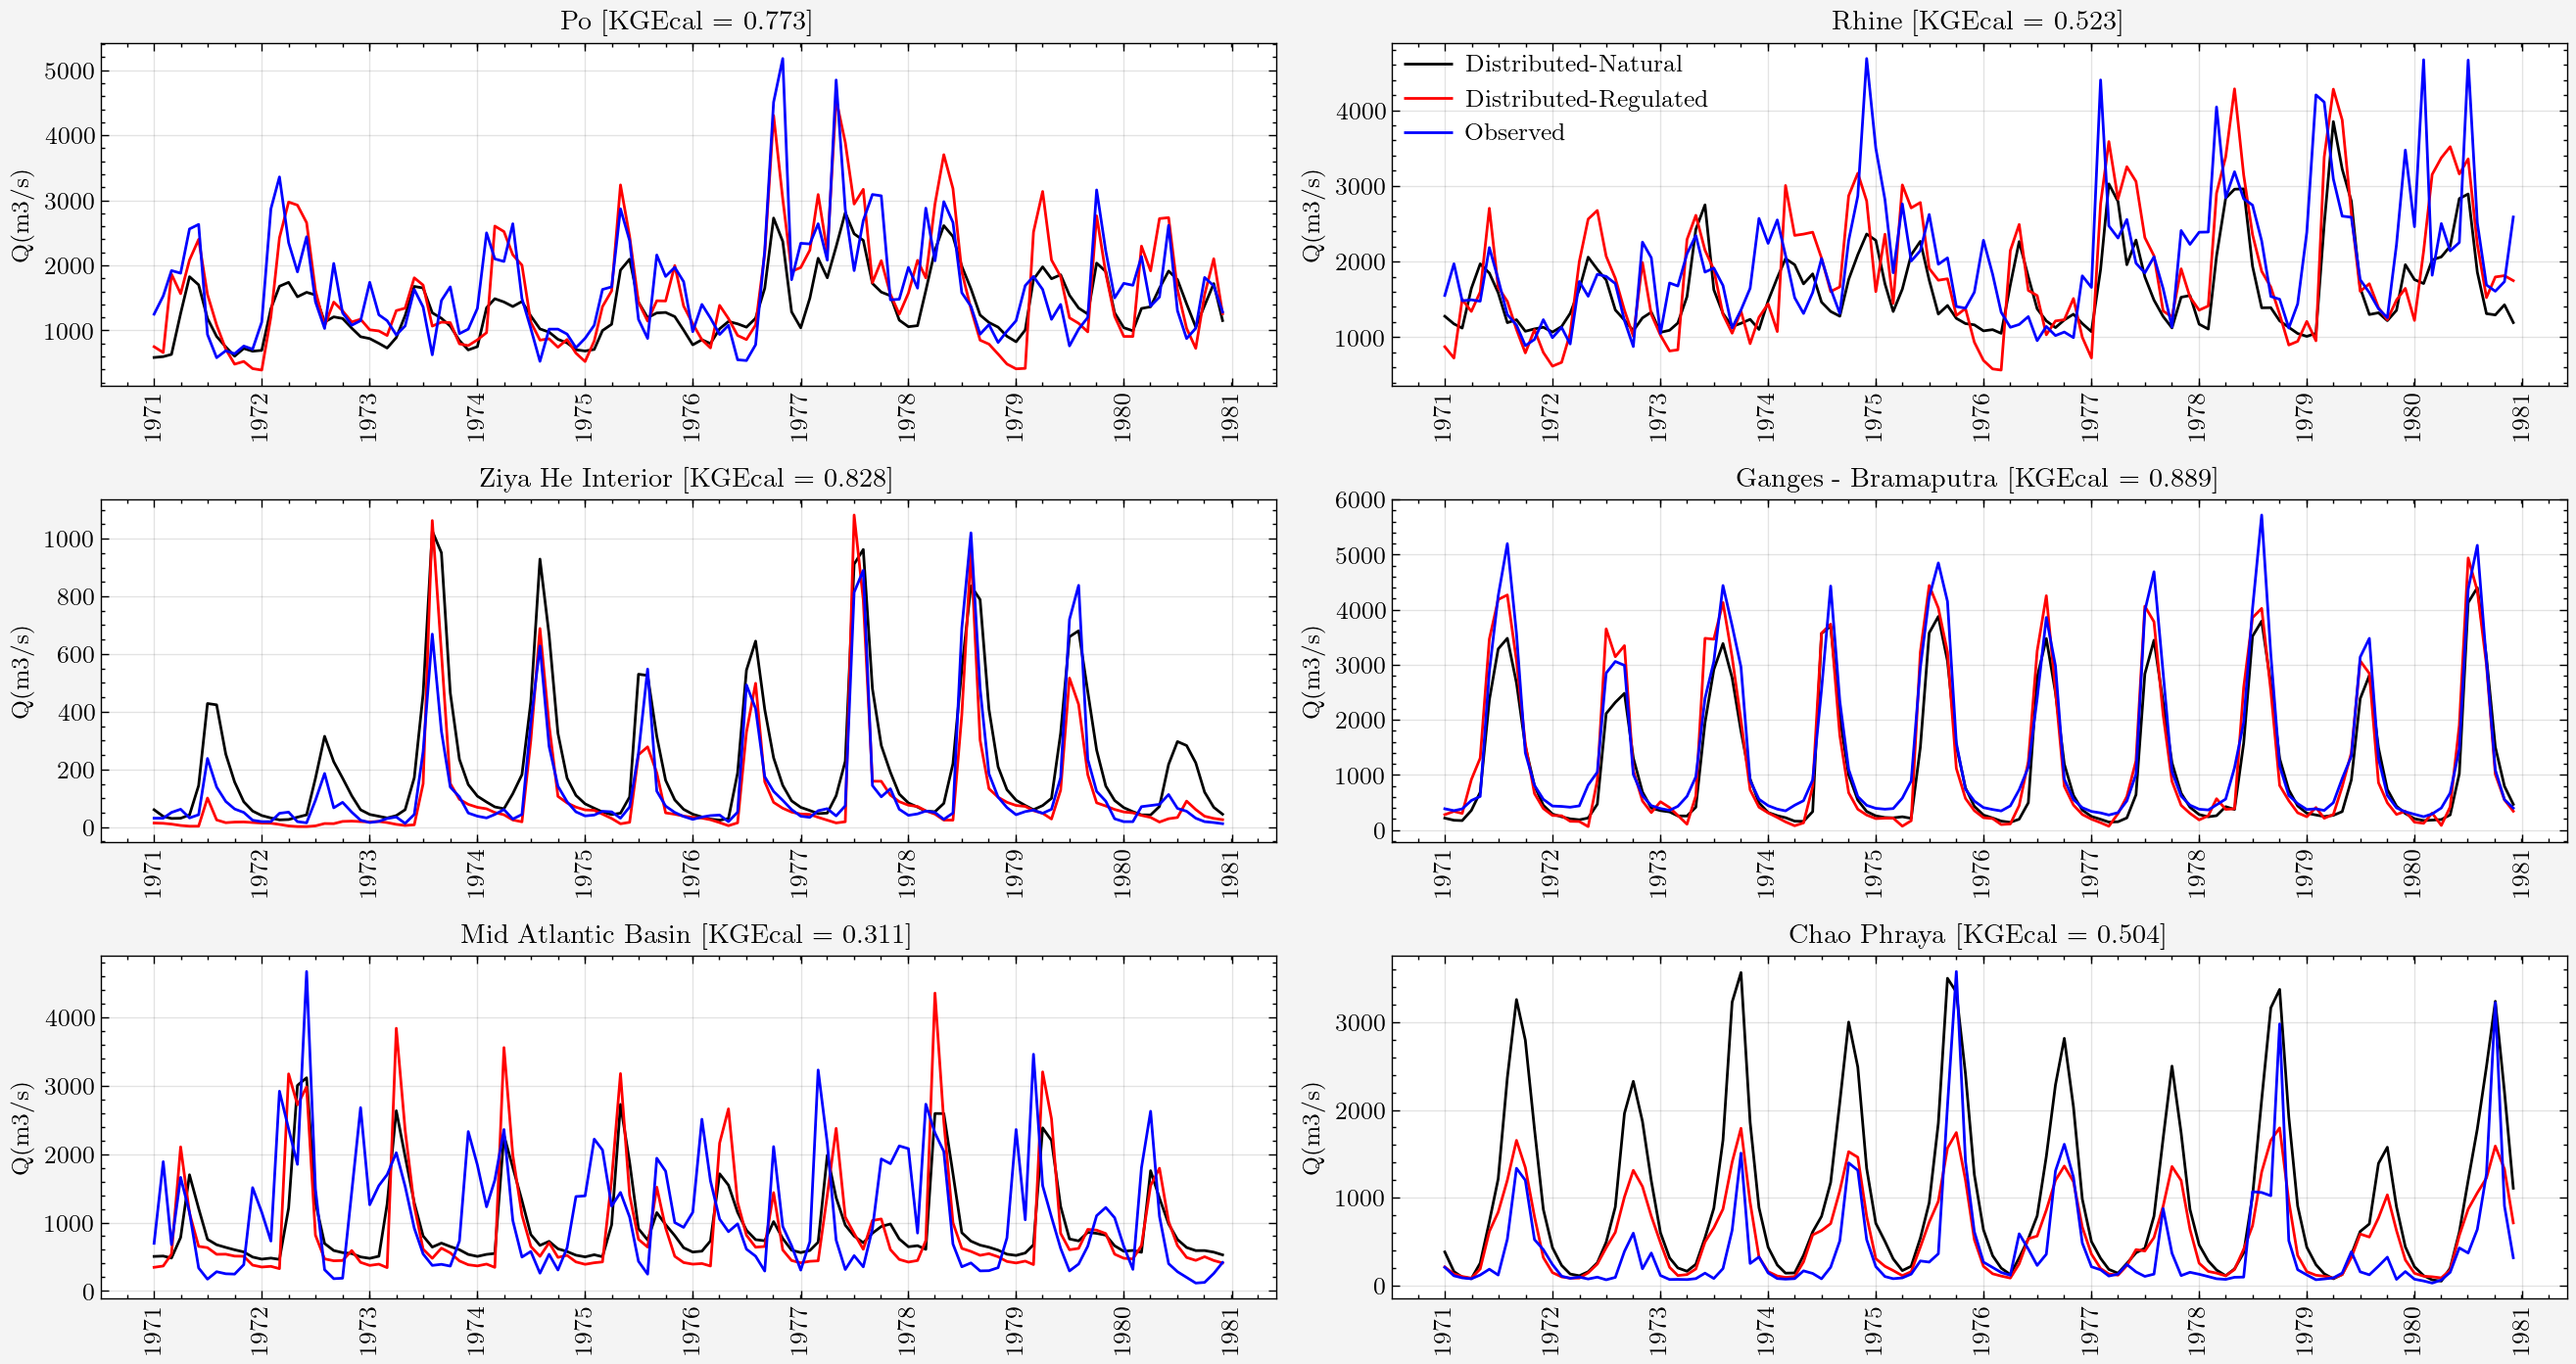

In [4]:
file_dir_watch_vald = dir_in + '/Simulated/SimulatedFinal-HP/flow/'
file_dir_watch_natr = dir_in + '/Simulated/SimulatedFinal-YL/flow/'

#basin_4 = basins94[mm]
basin_slt = [57, 32, 77, 110, 233, 146]
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, ax = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=1.750, refwidth=6.0, share=0)#, journal='pnas2')
    for jj in range(6):
        basin_num = basin_slt[jj]    
        ii = np.where(basins91==basin_num)[0][0]
        basin_num = basins91[ii]    

        ## observed
        aa = (grdc_basin_m3persec['basin'] == basin_num)
        grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
        qobs_calibration= grdc_m3persec[0:120]
        qobs_validation = grdc_m3persec[120:240]    
        qobs_calibration_ts = timeseries_coverter(qobs_calibration, start_yr=1971, ending_yr=1980)

        ## simulated
        data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy') 
        qsim_calibration= data_basin[0:120]
        qsim_validation = data_basin[120:240]
        qsim_calibration_ts = timeseries_coverter(qsim_calibration, start_yr=1971, ending_yr=1980)

        ## Natural
        data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration_yl= data_basin_yl[0:120]
        qsim_validation_yl = data_basin_yl[120:240]
        qsim_calibration_tsyl = timeseries_coverter(qsim_calibration_yl, start_yr=1971, ending_yr=1980)

        # KGE
        kge_cal = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 

        # plotting
        ax[jj].plot(qsim_calibration_tsyl, 'k', label='Distributed-Natural')
        ax[jj].plot(qsim_calibration_ts, 'r', label='Distributed-Regulated')
        ax[jj].plot(qobs_calibration_ts, 'b', label='Observed')
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_91[ii])
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_91[ii] + ' [KGEcal = '+ str(np.round(kge_cal,3))  +']')

        if jj==1:
            ax[jj].legend(ncols=1)

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
#plt.savefig("Calibration.png", **SAVE_KWDS)  

## Validation

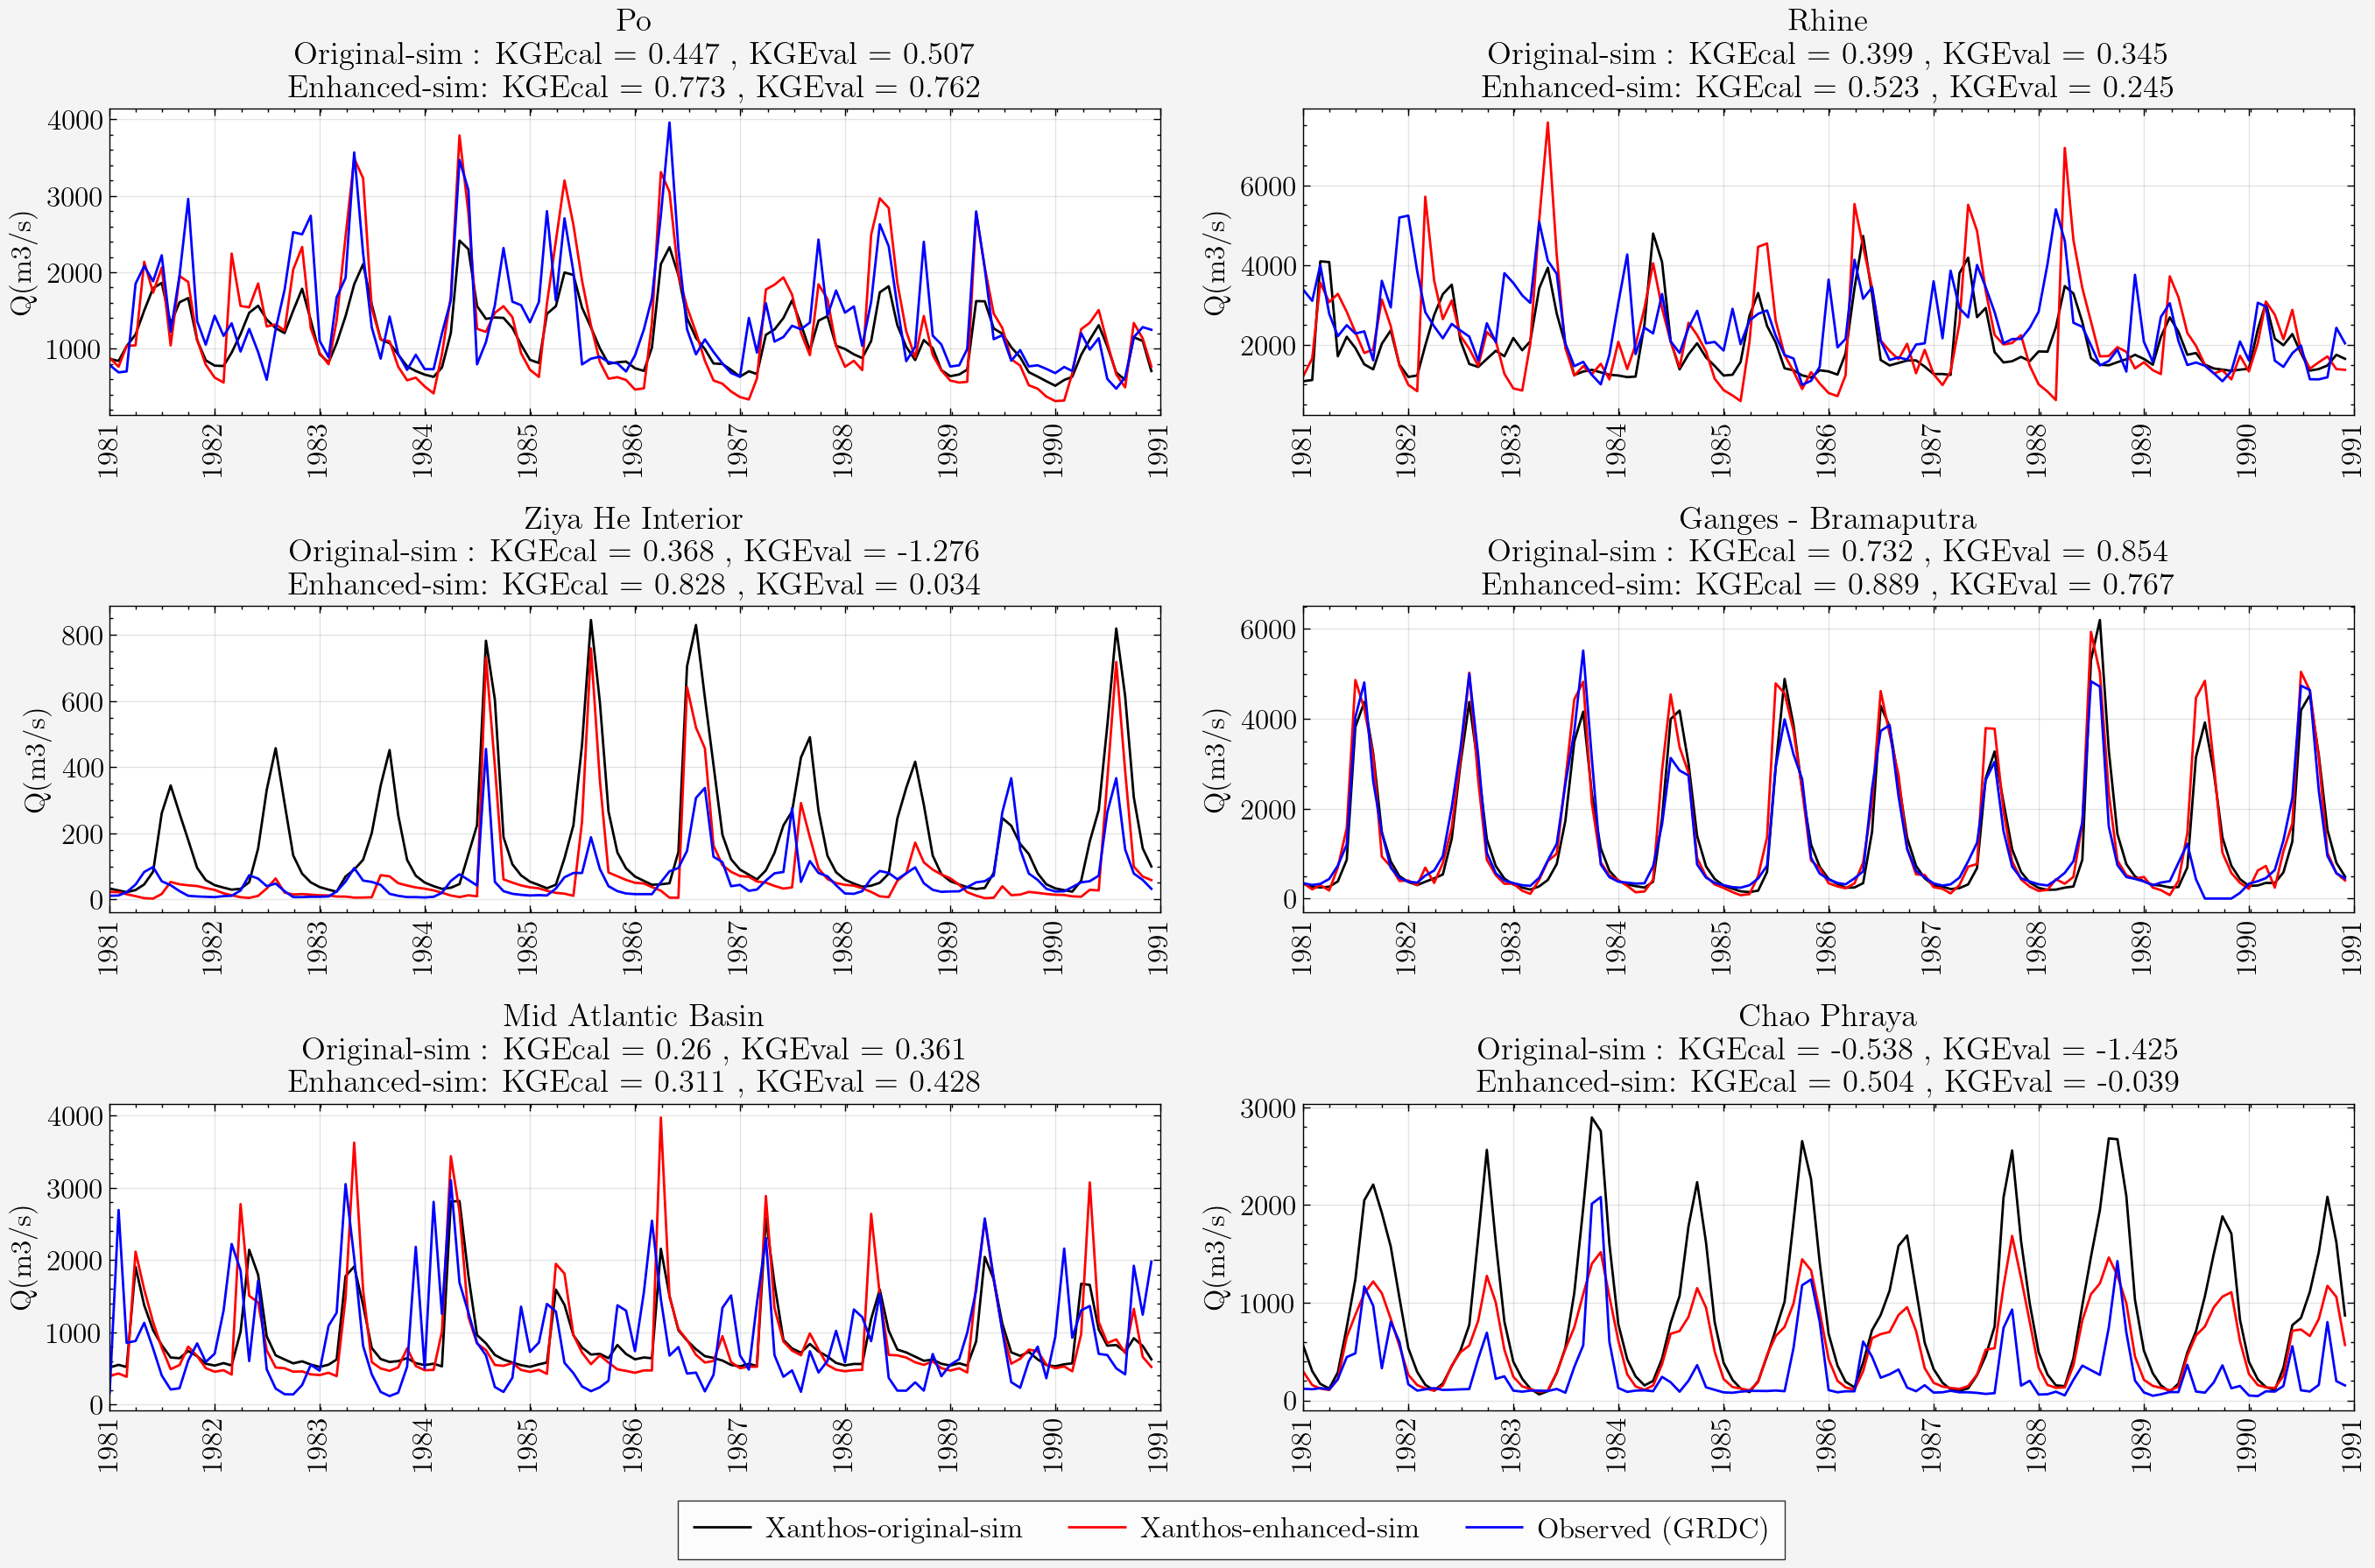

In [5]:
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

basin_slt = [57, 32, 77, 110, 233, 146]
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    fig, ax = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=1.750, refwidth=6.0, share=0)#, journal='pnas2')
    for jj in range(6):
        basin_num = basin_slt[jj]    
        ii = np.where(basins91==basin_num)[0][0]

        basin_num = basins91[ii]    
        ## observed
        aa = (grdc_basin_m3persec['basin'] == basin_num)
        grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
        qobs_calibration= grdc_m3persec[0:120]
        qobs_validation = grdc_m3persec[120:240]    
        qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

        ## simulated
        data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration= data_basin[0:120]
        qsim_validation = data_basin[120:240]
        qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

        ## Natural
        data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
        qsim_calibration_yl= data_basin_yl[0:120]
        qsim_validation_yl = data_basin_yl[120:240]
        qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
        

        # KGE : regulated
        kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
        kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
        # KGE : natural
        kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
        kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 


        # plotting
        hs=ax[jj].plot(qsim_validation_tsyl, 'k', label='Xanthos-original-sim')
        h1 = ax[jj].plot(qsim_validation_ts, 'r', label='Xanthos-enhanced-sim')
        hs.append(h1)
        h2 = ax[jj].plot(qobs_validation_ts, 'b', label='Observed (GRDC)')
        hs.append(h2)    
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_91[ii])
        ax[jj].format(ylabel = 'Q(m3/s)', title = basinName_91[ii] +    '\n'
                    'Original-sim : KGEcal = '+ str(np.round(kge_caln,3)) + ' , ' + 'KGEval = '+ str(np.round(kge_valn,3))  + '\n'
                    'Enhanced-sim: KGEcal = '+ str(np.round(kge_calr,3)) + ' , ' + 'KGEval = '+ str(np.round(kge_valr,3)) )
        ax[jj].tick_params(axis='both', which='major', labelsize=12)
        ax[jj].set_xlim([date(1980, 12, 31), date(1991, 1, 1)])


        #if jj==5:
    #    ax[jj].legend(ncols=3, location='b')

fig.legend(hs, ncols=3, center=True, frame=True, loc='b', fontsize=12)
plt.tight_layout()

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig("dir_out + Figure-10.png", **SAVE_KWDS)  